In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
size = 224
bs = 4

In [5]:
dataDir = "/home/tako/devtools/furry-geras/coco"
dataType = "val2017"
annFile = "{}/instances_{}.json".format(dataDir, dataType)

images, lbl_bbox = get_annotations(annFile)
img2bbox = dict(zip(images, lbl_bbox))


In [6]:
get_y_func = lambda o:img2bbox[o.name] if o.name in img2bbox else [None,None]
print(get_y_func(Path("coco/val2017/000000140286.jpg")))
print(get_y_func(Path("coco/val2017/000000200152.jpg")))

[[[249.08, 96.54, 445.64, 269.15000000000003], [226.35, 417.67, 328.07, 517.57], [265.36, 254.83, 337.95000000000005, 282.93]], ['horse', 'person', 'person']]
[None, None]


In [7]:
def get_y_func(o):
    result = [[],[]]
    if o.name in img2bbox:
        lbl_bbox = img2bbox[o.name] 
    else:
        return [None,None]
    result = Tensor([,80])
    return result

print(get_y_func(Path("coco/val2017/000000140286.jpg")))
print(get_y_func(Path("coco/val2017/000000200152.jpg")))

[[[226.35, 417.67, 328.07, 517.57], [265.36, 254.83, 337.95000000000005, 282.93]], ['person', 'person']]
[None, None]


In [8]:
def remove_non_human(f):
    classes = get_y_func(f)[1]
    if classes is None:
        return False
    return 'person' in classes

print(remove_non_human(Path("coco/val2017/000000140286.jpg")))
print(remove_non_human(Path("coco/val2017/000000200152.jpg")))

True
False


In [9]:
src = (ObjectItemList.from_folder('coco/val2017')
        .filter_by_func(remove_non_human)
        #Where are the images?
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
       )
src

LabelLists;

Train: LabelList
y: ObjectCategoryList (2155 items)
[ImageBBox (521, 640), ImageBBox (393, 640), ImageBBox (424, 640), ImageBBox (427, 640), ImageBBox (426, 640)]...
Path: coco/val2017
x: ObjectItemList (2155 items)
[Image (3, 521, 640), Image (3, 393, 640), Image (3, 424, 640), Image (3, 427, 640), Image (3, 426, 640)]...
Path: coco/val2017;

Valid: LabelList
y: ObjectCategoryList (538 items)
[ImageBBox (480, 640), ImageBBox (428, 640), ImageBBox (640, 427), ImageBBox (622, 640), ImageBBox (480, 640)]...
Path: coco/val2017
x: ObjectItemList (538 items)
[Image (3, 480, 640), Image (3, 428, 640), Image (3, 640, 427), Image (3, 622, 640), Image (3, 480, 640)]...
Path: coco/val2017;

Test: None

Note the size differences. In other areas this does not seem to be a problem. However here it seems it does.

In [10]:
tfms = get_transforms() # or tfms=None if none are needed
data = src.transform(tfms=tfms, tfm_y=True, size=128 )
data

LabelLists;

Train: LabelList
y: ObjectCategoryList (2155 items)
[ImageBBox (521, 640), ImageBBox (393, 640), ImageBBox (424, 640), ImageBBox (427, 640), ImageBBox (426, 640)]...
Path: coco/val2017
x: ObjectItemList (2155 items)
[Image (3, 521, 640), Image (3, 393, 640), Image (3, 424, 640), Image (3, 427, 640), Image (3, 426, 640)]...
Path: coco/val2017;

Valid: LabelList
y: ObjectCategoryList (538 items)
[ImageBBox (480, 640), ImageBBox (428, 640), ImageBBox (640, 427), ImageBBox (622, 640), ImageBBox (480, 640)]...
Path: coco/val2017
x: ObjectItemList (538 items)
[Image (3, 480, 640), Image (3, 428, 640), Image (3, 640, 427), Image (3, 622, 640), Image (3, 480, 640)]...
Path: coco/val2017;

Test: None

In [11]:
data = data.databunch(bs=bs, collate_fn=bb_pad_collate,num_workers=4).normalize()

As I understand this error it means that the image size do not match however I did specify the desired size.

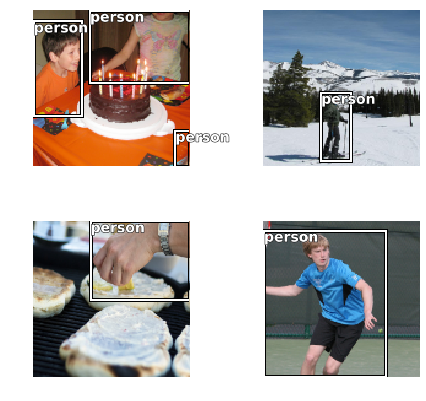

In [12]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(6,6))

In [80]:
data.train_ds[0][1]

ImageBBox (128, 128)

In [81]:
from torch.nn import L1Loss

def loss_fn(out, *yb):
    print(out.shape,[y.shape for y in yb])
    return 0

In [82]:
from fastai.callbacks.hooks import num_features_model
class PersonDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return x.sigmoid_() 
f = PersonDetector()


In [83]:
learn = create_cnn(data, PersonDetector(), loss_func = loss_fn)
learn.fit(1)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not bool